# Nicolaus Copernicus University summer internship project 
## Natural Language Processing applied to ancient language texts

We aim to investigate the implementation of a general pipeline to extract qualitative and quantitative information from Latin texts employing ML algorithms. In particular, our approach focuses on detecting similarities between texts of the same author. For instance, it could
be beneficial to classify authors according to writing styles or historical ages, as well as to recognize the author of anonymous documents with a certain probability. \\

Finally, we propose a network representation that aims to capture and represent these similarities, and we quantify the degree of relationship by computing a similarity index.

In [2]:
#Install the necessary libraries
!wget --no-check-certificate --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1Te_14UB-DZ8wYPhHGyDg7LadDTjNzpti' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1Te_14UB-DZ8wYPhHGyDg7LadDTjNzpti" -O latin_bert.tar && rm -f /tmp/cookies.txt
!mkdir models
!mv latin_bert.tar models/
!cd models
!tar -xf models/latin_bert.tar
!git clone https://github.com/pietro-sillano/LatinBERT LatinBERT
!pip install cltk==1.0.16
!pip install pygame  beautifulsoup4==4.9.1 cltk nltk==3.6.2 future==0.18.2 numpy tensor2tensor PyYAML==5.4.1 tokenizers==0.8.1rc2 transformers==3.1.0 tqdm==4.48.2 Unidecode==1.1.1 gensim==3.8.3
!pip install --upgrade scikit-learn
!pip install --upgrade spacy
!pip install --upgrade spacy
!pip install umap-learn
!pip install umap-learn[plot]

--2021-07-21 15:05:05--  https://docs.google.com/uc?export=download&confirm=cnSQ&id=1Te_14UB-DZ8wYPhHGyDg7LadDTjNzpti
Resolving docs.google.com (docs.google.com)... 173.194.76.139, 173.194.76.101, 173.194.76.113, ...
Connecting to docs.google.com (docs.google.com)|173.194.76.139|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0c-bg-docs.googleusercontent.com/docs/securesc/gg2dc11tbbj4iqm34j1fk2agrl8cg0bi/889bac0g0faiqu9740526mne6cnc8nc3/1626879900000/09859182337762586004/02816191131005191603Z/1Te_14UB-DZ8wYPhHGyDg7LadDTjNzpti?e=download [following]
--2021-07-21 15:05:05--  https://doc-0c-bg-docs.googleusercontent.com/docs/securesc/gg2dc11tbbj4iqm34j1fk2agrl8cg0bi/889bac0g0faiqu9740526mne6cnc8nc3/1626879900000/09859182337762586004/02816191131005191603Z/1Te_14UB-DZ8wYPhHGyDg7LadDTjNzpti?e=download
Resolving doc-0c-bg-docs.googleusercontent.com (doc-0c-bg-docs.googleusercontent.com)... 74.125.140.132, 2a00:1450:400c:c08::84
Connecting

In [7]:
#Import the necessary libraries
import re
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn import metrics
import pandas as pd
#import cltk
#from cltk import embeddings
import sys
import os
import umap
import umap.plot
import numpy as np
import networkx as nx
syspath = 'LatinBERT/'
if syspath not in sys.path:
    sys.path.append(syspath)

from cltk.data.fetch import FetchCorpus
from cltk.tokenizers.lat.lat import LatinWordTokenizer as WordTokenizer
from cltk.sentence.lat import LatinPunktSentenceTokenizer as SentenceTokenizer
from cltk import NLP

corpus_downloader = FetchCorpus(language="lat")
corpus_downloader.list_corpora
corpus_downloader.import_corpus("lat_models_cltk")

cltk_nlp = NLP(language="lat")

from latbert import LatinBERT


tokenizerPath = 'LatinBERT/latin.subword.encoder'
bertPath = 'latin_bert/'
bert=LatinBERT(tokenizerPath=tokenizerPath, bertPath=bertPath)

‎𐤀 CLTK version '1.0.16'.
Pipeline for language 'Latin' (ISO: 'lat'): `LatinNormalizeProcess`, `LatinStanzaProcess`, `LatinEmbeddingsProcess`, `StopsProcess`, `LatinNERProcess`, `LatinLexiconProcess`.


# NLP with Latin-Bert

In [36]:
df=pd.read_csv('prose_by_authors')    #read the dataset 
df=df.drop(labels=[6,7,10], axis=0)   #6,7,10 give problem, I delete them
df=df.sample(frac=1)
df=df.reset_index()
df

,index,text,label,author,age
0,76,Exigitis rem magis iucundam mihi quam facilem;...,19,SENECA MAIOR,54 B.C.-39 A.D.
1,96,"Axius, Tuas partes, inquit, sublevavit Appius,...",23,VARRO,116-27 B.C.
2,83,Inquiro de te et ab omnibus sciscitor qui ex i...,20,SENECA MINOR,C.4 B.C.-A.D. 65
3,34,"Romanum imperium, quo neque ab exordio ullum f...",10,EUTROPIUS,4TH CENTURY A.D.
4,73,Si advorsus vos patriamque et deos penatis tot...,18,SALLUST,86-34 B.C
...,...,...,...,...,...
90,45,Statuas sane Aelio Vero per totum orbem coloss...,13,GELLIUS,4TH CENTURY A.D.
91,16,"Lucius Tarquinius Priscus, Demarati Corinthii ...",5,AURELIUS VICTOR,4th century A.D.
92,63,Quod semel atque iterum consul fuisti similis ...,16,PLINY MINOR,63-C.113 A.D.
93,41,"P. Scipio in Hispania, cum comperisset Hasdrub...",12,FRONTINUS,C.40-103 A.D.


In [37]:
#preprocessing
docs=[] 
docs_labels=[]                           
for i in range(len(df)):
  t=re.sub(r'[^\w\s]', '', df['text'][i])
  t=t.lower()
  docs.append(re.sub(r'[0-9]+', '', t))
  docs_labels.append((re.sub(r'[0-9]+', '', t),df['label'][i]))

In [38]:
#documents embedding with latin bert
bert_sents=bert.get_berts(docs,docs_labels)

In [39]:
#at each document corresponds a vector
vec=[]
for i in range(len(bert_sents)):
  vec.append(bert_sents[i][0][1])
X=np.array(vec)
np.shape(X)

(95, 768)

In [40]:
y=np.array(df['label'])      #labels
auth=df['author']      #authors

# Cosine similarity

In [41]:
cos=pd.DataFrame(metrics.pairwise.cosine_similarity(X))
cos

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94
0,1.000000,0.760242,0.882533,0.726586,0.777721,0.809722,0.725107,0.787545,0.784659,0.825379,0.730580,0.720420,0.683385,0.745102,0.890862,0.728627,0.840121,0.700118,0.747852,0.726900,0.666224,0.872108,0.708524,0.775103,0.872630,0.776354,0.753995,0.737532,0.770411,0.770818,0.698915,0.887703,0.727219,0.709374,0.787939,0.741628,0.749872,0.758975,0.751519,0.877058,...,0.724736,0.770998,0.752144,0.793545,0.810742,0.855911,0.750159,0.665053,0.738992,0.727940,0.696274,0.660097,0.756383,0.697463,0.848263,0.738673,0.745171,0.687283,0.884569,0.701997,0.789009,0.723875,0.745971,0.769141,0.818955,0.773337,0.743580,0.766993,0.741862,0.764133,0.719894,0.760578,0.705107,0.716811,0.707974,0.792625,0.680489,0.850214,0.743481,0.760662
1,0.760242,1.000000,0.797360,0.772231,0.706445,0.804011,0.788948,0.745246,0.762676,0.866063,0.773390,0.699630,0.732890,0.720636,0.834745,0.755018,0.820433,0.671394,0.729675,0.779879,0.756934,0.812015,0.740603,0.751144,0.833167,0.732845,0.807960,0.765767,0.750170,0.742945,0.682687,0.815302,0.801891,0.760008,0.729398,0.706831,0.783888,0.905545,0.787688,0.800105,...,0.775921,0.752348,0.782842,0.753957,0.785291,0.804712,0.713316,0.760668,0.778153,0.709399,0.714947,0.742689,0.730728,0.773834,0.785861,0.778456,0.792264,0.708539,0.790657,0.753498,0.761353,0.748746,0.741190,0.806913,0.746132,0.827754,0.769826,0.763859,0.744102,0.708078,0.703389,0.797836,0.740229,0.802682,0.696823,0.785445,0.721021,0.782983,0.794889,0.746306
2,0.882533,0.797360,1.000000,0.718371,0.745411,0.760679,0.729416,0.738678,0.737562,0.853032,0.757558,0.715600,0.655589,0.710131,0.904914,0.720736,0.853882,0.678039,0.690054,0.722424,0.637181,0.863952,0.704019,0.745064,0.935988,0.765522,0.758473,0.749892,0.741647,0.728192,0.676348,0.939526,0.719237,0.721481,0.757751,0.752241,0.736397,0.765367,0.749982,0.914853,...,0.729146,0.743274,0.738322,0.757007,0.785617,0.881022,0.719343,0.674813,0.767686,0.706685,0.662852,0.654232,0.764197,0.709201,0.885856,0.717832,0.748010,0.668263,0.938481,0.681981,0.756867,0.720728,0.759910,0.774086,0.773728,0.778990,0.731522,0.751725,0.732756,0.778261,0.721850,0.734717,0.696970,0.730673,0.729514,0.756497,0.662643,0.817319,0.759379,0.740884
3,0.726586,0.772231,0.718371,1.000000,0.756805,0.762293,0.867340,0.854187,0.792673,0.773165,0.878662,0.758321,0.855797,0.823001,0.792355,0.839477,0.756097,0.729909,0.763701,0.835213,0.744888,0.750143,0.788667,0.820288,0.745296,0.733196,0.841180,0.876647,0.845812,0.815797,0.844471,0.739661,0.854596,0.873250,0.744682,0.754525,0.738395,0.788630,0.901475,0.763187,...,0.843391,0.864094,0.825225,0.744451,0.816630,0.772896,0.811586,0.724326,0.827073,0.801592,0.722666,0.762033,0.771738,0.801664,0.752046,0.851120,0.838986,0.707601,0.716116,0.815280,0.808223,0.899549,0.802661,0.869015,0.819470,0.857029,0.715473,0.838677,0.814206,0.736009,0.759241,0.884044,0.803651,0.828896,0.727416,0.824136,0.885760,0.778075,0.865260,0.847473
4,0.777721,0.706445,0.745411,0.756805,1.000000,0.790202,0.794030,0.852751,0.764925,0.726757,0.766675,0.695094,0.733456,0.854401,0.749735,0.734039,0.788793,0.767254,0.727793,0.753614,0.668717,0.768948,0.764723,0.786125,0.725435,0.918705,0.791225,0.802428,0.761507,0.735511,0.731165,0.736586,0.774988,0.776618,0.896294,0.756935,0.764850,0.709055,0.734095,0.738099,...,0.702947,0.784674,0.790938,0.824839,0.761775,0.732543,0.725383,0.693211,0.750242,0.774306,0.740466,0.720565,0.788374,0.739761,0.743314,0.741527,0.759853,0.660895,0.707849,0.744784,0.757712,0.775207,0.770441,0.746940,0.755253,0.805985,0.714430,0.767813,0.746803,0.790669,0.766012,0.742596,0.733891,0.764293,0.748801,0.740453,0.708261,0.793035,0.808140,0.769029
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [42]:
np.array(cos).min()

0.59793365

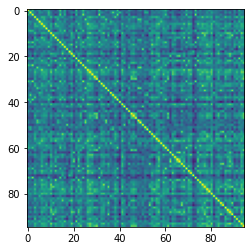

In [43]:
plt.imshow(cos.to_numpy())

# Data visualization - UMAP

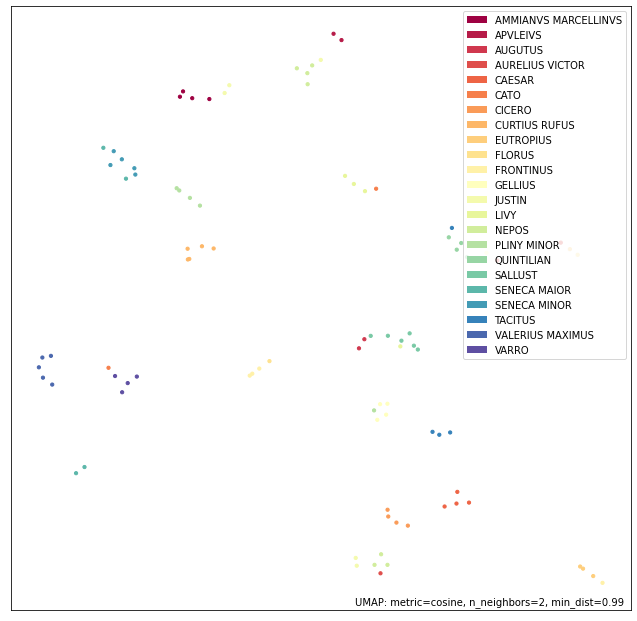

In [44]:
#dimensionality reduction with UMAP and graphical representation - plot 1
mapper = umap.UMAP(random_state=42, n_components=2, min_dist=0.99, metric='cosine', n_neighbors=2).fit(X)
umap.plot.points(mapper, labels=auth)

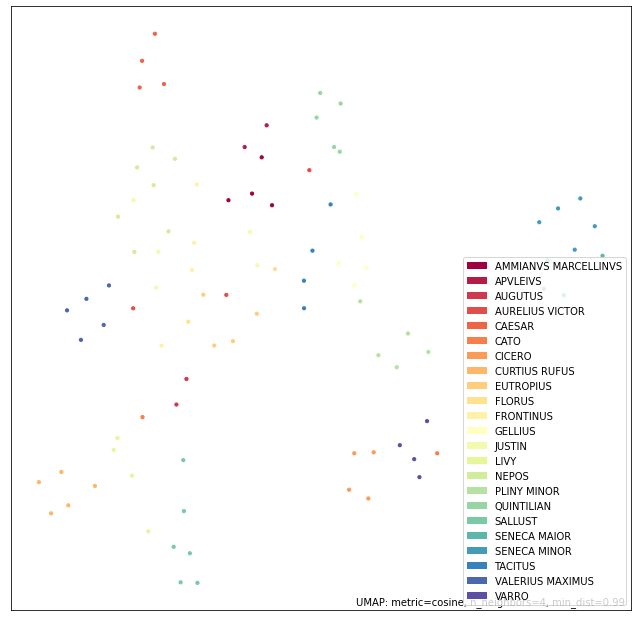

In [45]:
#dimensionality reduction with UMAP and graphical representation - plot 2, different parameters
mapper = umap.UMAP(random_state=42, n_components=2, metric='cosine',n_neighbors=4, min_dist=0.99).fit(vec)
umap.plot.points(mapper, labels=df['author'])

# Multiclass classification

In [12]:
#import the machine learning libraries
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import rand_score

### Clustering with K-means

In [13]:
kmeans_labels = KMeans(random_state=0, n_clusters=23).fit_predict(X)  #mapper.transform(X)
kmeans_labels, y

(array([11,  0, 13,  4,  5, 19, 11,  6,  3, 14,  4,  6,  4, 10,  2,  1, 19,
         5, 11,  1, 14, 17,  9,  4, 12, 15,  1, 14,  1, 19, 20,  6,  4,  1,
        15,  2,  7, 11,  6, 22,  9,  4, 17,  9,  1,  7,  9,  8,  8,  1, 17,
         2,  9,  3,  1,  3, 21,  7, 16, 18, 16, 10, 10, 10,  3,  5,  9,  8,
         1, 20, 10,  7, 22,  1, 19, 11,  3,  9, 16,  9,  5, 10, 10,  8,  0,
         9,  4,  4, 16,  4,  2, 10,  7,  1, 12], dtype=int32),
 array([22,  3, 14, 20,  9,  6, 22,  4, 18, 21, 20,  4, 19, 15, 16,  7, 14,
         9, 22, 12, 21, 10, 17, 20,  1,  7, 12, 21, 10, 14, 11,  4, 19, 12,
         7, 16,  6, 22,  4,  2,  5, 20,  5, 17, 10, 23, 17, 13, 13, 11, 10,
        16, 17, 18,  1, 18, 18, 23,  8,  9,  8, 15,  7, 15, 18,  9, 17, 13,
         7,  5, 15, 23,  2, 12, 14, 22, 18, 21,  8, 16,  9, 15, 15, 13,  3,
        13, 20, 19,  8, 19, 16, 15, 23,  1,  1]))

In [14]:
rand_score(kmeans_labels,y)

0.9657334826427771

### Model selection - supervised

In [15]:
clf = OneVsRestClassifier(SVC())
scores = cross_val_score(clf, X, y, cv=5)
scores, np.mean(scores)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


(array([0.84210526, 0.68421053, 0.84210526, 0.78947368, 0.84210526]), 0.8)

In [18]:
clf = OneVsRestClassifier(MLPClassifier(random_state=1, max_iter=300, activation='relu'))
scores = cross_val_score(clf, X, y, cv=5)
scores, np.mean(scores)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


(array([0.89473684, 0.84210526, 0.78947368, 0.73684211, 0.89473684]),
 0.8315789473684211)

In [19]:
clf = KNeighborsClassifier(n_neighbors=1)
scores = cross_val_score(clf, X, y, cv=5)
scores, np.mean(scores)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


(array([0.68421053, 0.78947368, 0.89473684, 0.78947368, 0.84210526]), 0.8)

### Compute the probability of belonging to a certain class

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=10)

In [21]:
pref = KNeighborsClassifier(n_neighbors=1).fit(X_train, y_train)

In [22]:
pref = OneVsRestClassifier(MLPClassifier(random_state=1, max_iter=300, activation='relu')).fit(X_train, y_train)

In [23]:
pref.score(X_test, y_test)

0.8421052631578947

In [24]:
prob=pref.predict_proba(X_test)

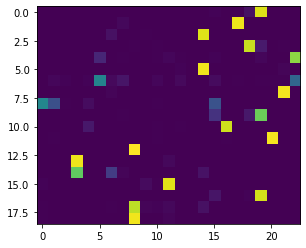

In [25]:
plt.imshow(prob)

# Network of authors

In [13]:
df=pd.read_csv('prose_by_authors')    #read the dataset 
df=df.drop(labels=[6,7,10], axis=0)   #6,7,10 give problem, I delete them
df=df.reset_index()
df

,index,text,label,author,age
0,0,Post emensos insuperabilis expeditionis eventu...,1,AMMIANVS MARCELLINVS,4th century A.D.
1,1,Intercluso hac bellorum difficili sorte Consta...,1,AMMIANVS MARCELLINVS,4th century A.D.
2,2,"Dum apud Persas, ut supra narravimus, perfidia...",1,AMMIANVS MARCELLINVS,4th century A.D.
3,3,"Post exploratam alacritatem exercitus, uno par...",1,AMMIANVS MARCELLINVS,4th century A.D.
4,4,Thessaliam — nam et illic originis maternae no...,2,APVLEIVS,4th century A.D.
...,...,...,...,...,...
90,93,"Non tam robusti generis humanitas, sed et ipsa...",22,VALERIUS MAXIMUS,1ST CENTURY A.D.
91,94,"Vide, inquit Atticus, ne te fallat et novenae ...",23,VARRO,116-27 B.C.
92,95,Sed quoniam agri culturae quod esset initium e...,23,VARRO,116-27 B.C.
93,96,"Axius, Tuas partes, inquit, sublevavit Appius,...",23,VARRO,116-27 B.C.


In [14]:
#preprocessing
docs=[] 
docs_labels=[]                           
for i in range(len(df)):
  t=re.sub(r'[^\w\s]', '', df['text'][i])
  t=t.lower()
  docs.append(re.sub(r'[0-9]+', '', t))
  docs_labels.append((re.sub(r'[0-9]+', '', t),df['label'][i]))

#documents embedding with latin bert
bert_sents=bert.get_berts(docs,docs_labels) 

#at each document corresponds a vector
vec=[]
for i in range(len(bert_sents)):
  vec.append(bert_sents[i][0][1])

In [15]:
df2=pd.DataFrame({'vec': vec, 'author': df['author'], 'labels':df['label']}) 
df2=df2.set_index('author')
df2

,vec,labels
author,,
AMMIANVS MARCELLINVS,"[0.07418423, -0.39388084, 0.8522287, -0.001568...",1
AMMIANVS MARCELLINVS,"[0.14961854, -0.57052547, 0.5068771, -0.137334...",1
AMMIANVS MARCELLINVS,"[-0.099837266, -0.5141671, 0.8572278, 0.145761...",1
AMMIANVS MARCELLINVS,"[0.3848191, -0.28898844, 0.7875856, 0.09586301...",1
APVLEIVS,"[0.1286606, -0.80709696, 0.21628845, -0.225734...",2
...,...,...
VALERIUS MAXIMUS,"[-0.21659768, -0.40270364, 0.55224466, -0.0621...",22
VARRO,"[0.6546804, -0.40994716, -0.1354118, -0.005702...",23
VARRO,"[0.5914808, -0.1173463, -0.09561266, -0.099045...",23


In [62]:
vm=[]
auth_unique=set(auth)
for a in list(auth_unique):
  vm.append(np.mean(np.array(df2.loc[a])))

vm=np.array(vm)
np.shape(vm)

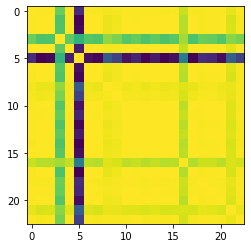

In [75]:
#cosine similarity
cos=pd.DataFrame(metrics.pairwise.cosine_similarity(vm))   #mapper.transform(vm)
plt.imshow(cos)

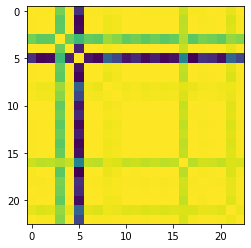

In [76]:
#rescale
cos=1-1/np.array(cos)
cos=MinMaxScaler().fit_transform(cos)
plt.imshow(cos)

In [82]:
np.array(cos).mean(), np.array(cos).min()

(0.86839354, 0.0)

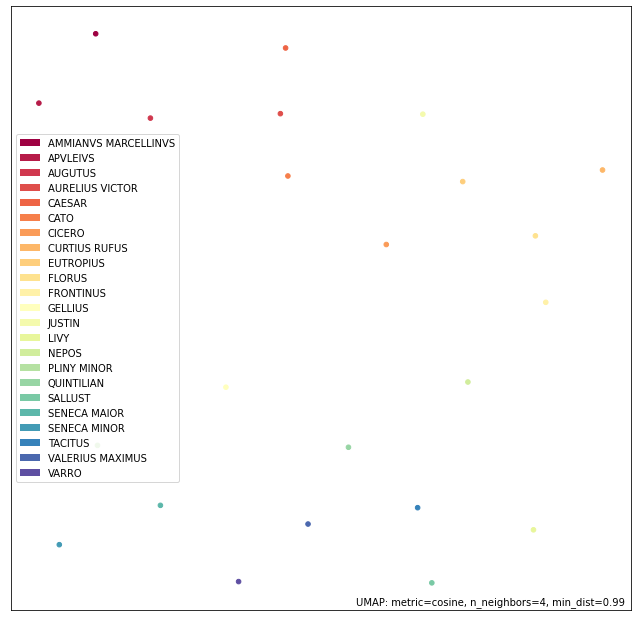

In [89]:
#dimensionality reduction with UMAP and graphical representation - plot 1
mapper = umap.UMAP(random_state=42, n_components=2, min_dist=0.99, metric='cosine', n_neighbors=4).fit(vm)
#position - the same as umap
p=mapper.transform(vm)
#plot
umap.plot.points(mapper, labels=np.array(list(auth_unique)))

In [92]:
li=[]
col=[]

N=np.shape(cos)[0]

for i in range(N):
    for j in range(N):
      if cos[i][j]!=0:
        li.append([i,j,cos[i][j]])

for i in range(len(li)):
    col.append(li[i][2])

G1 = nx.DiGraph() 
G1.add_weighted_edges_from(li)

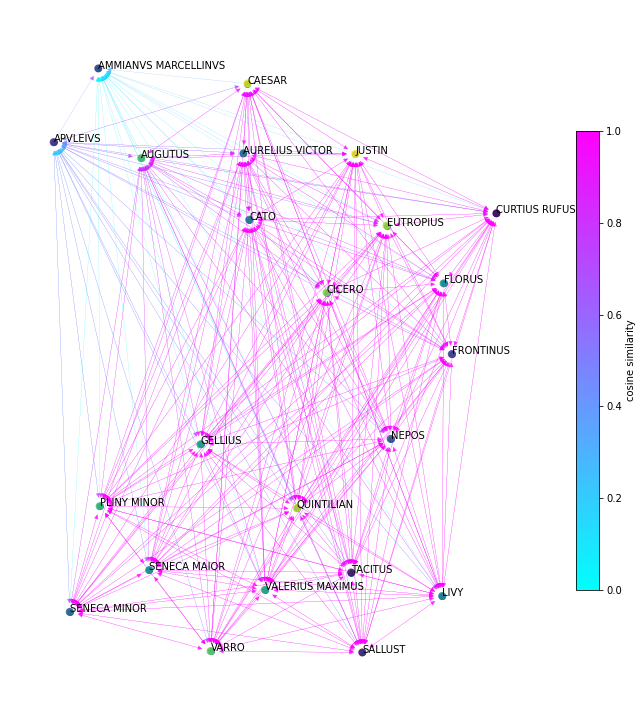

In [94]:
#Plotting network with colormap based on cosine similarity
plt.figure(figsize=(12, 13))

vmin = 0   #np.min(np.array(cos))
vmax = 1   #np.max(np.array(cos))

edge=nx.draw_networkx_edges(G1, p, alpha=0.8, edge_color=col, width=0.2,  edge_vmin=vmin, edge_vmax=vmax, edge_cmap=plt.cm.cool) 

nx.draw_networkx_nodes(G1, p, node_size=50.0, node_color=range(len(auth_unique)), alpha=0.8)  


sm = plt.cm.ScalarMappable(cmap=plt.cm.cool, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])
cbar = plt.colorbar(sm,shrink=0.65, label="cosine similarity")

plt.scatter(p[:,0], p[:,1])
n=auth_unique
for i, txt in enumerate(n):
    plt.annotate(txt, (p[i,0], p[i,1]))

plt.axis('off')
plt.show()